# Importar librerias

In [7]:
# !pip install scikit-learn
# !pip install matplotlib
!pip install seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [34]:
%load_ext autoreload
%autoreload 2

import dgl
import torch
from torch.optim import Adam
import itertools
import torch.nn.functional as F


from modules.gnn import GNN
from modules.predictors import DotPredictor, MLPPredictor
from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
from utils import plot_roc_curve, plot_training

import pandas as pd

# Reload modulos automaticamente
# %load_ext autoreload
# %autoreload 2
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces


# from torch.optim import SparseAdam

# import matplotlib.pyplot as plt

# from modules.graph import Graph
# import numpy as np
# import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
ls data/DGL_Graph/DiGraph_AllFeatures/

edges.csv  meta.yaml  nodes.csv


In [3]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [ ]:
# data_path = "data/DGL_Graph/DiGraph_AllFeatures/"
# import pandas as pd

# # Cargar los archivos CSV
# edges = pd.read_csv("data/DGL_Graph/DiGraph_AllFeatures/edges.csv")
# nodes = pd.read_csv("data/DGL_Graph/DiGraph_AllFeatures/nodes.csv")

# # Obtener los conjuntos de nodos
# edge_nodes = set(edges['src_id']).union(set(edges['dst_id']))
# node_ids = set(nodes['node_id'])

# print(f"Total de nodos en edges.csv: {len(edge_nodes)}")
# print(f"Total de nodos en nodes.csv: {len(node_ids)}")

# # Verificar que todos los nodos en edges.csv estén presentes en nodes.csv
# missing_nodes = edge_nodes - node_ids
# if missing_nodes:
#     print(f"Faltan los siguientes nodos en nodes.csv: {missing_nodes}")
# else:
#     print("Todos los nodos en edges.csv están presentes en nodes.csv")

# print(f"Total de nodos: {len(missing_nodes)}")



Total de nodos en edges.csv: 74145
Total de nodos en nodes.csv: 74145
Todos los nodos en edges.csv están presentes en nodes.csv
Total de nodos: 0


# Diccionario de casos de prueba

In [101]:
cases = {
    "CASO_1": {
        "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
        "graph_type": "DiGraph",
        "features_type": "AllFeatures",
        "size_train": 0.8,
        "model": GCN,
        "predictor": DotPredictor,
        'description': 'GCN con predictor de Dot'
    },
    "CASO_2": {
        "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
        "graph_type": "MultiDiGraph",
        "features_type": "AllFeatures",
        "size_train": 0.8,
        "model": GCN,
        "predictor": MLPPredictor,
        'description': 'GCN con predictor de MLP'
    },
    "CASO_3": {
        "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
        "graph_type": "DiGraph",
        "features_type": "DegreeFeatures",
        "size_train": 0.8,
        "model": GraphSAGE,
        "predictor": DotPredictor,
        "description": "GraphSAGE con predictor de Dot"
    },
    "CASO 4: GraphSAGE + MLPPredictor": {
        "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
        "graph_type": "MultiDiGraph",
        "features_type": "DegreeFeatures",
        "size_train": 0.8,
        "model": GraphSAGE,
        "predictor": MLPPredictor,
    }
}

# Funciones Auxiliares

In [94]:

def load_and_prepare_data(data_path, size_train):
    gnn = GNN(debug=True)
    gnn.load_dataset(data_path, force_reload=True)
    gnn.split_dataset(size_train)
    # gnn.split_dtaset_v2()
    gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
    return gnn


def initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor = None):
    in_feats = gnn.dgl_graph.ndata['feat'].shape[1]

    model = model(in_feats, h_feats_model, out_feat_model)
    if predictor == DotPredictor:
        pred = predictor()
    else:
        # MLP Predictor
        pred = predictor( out_feat_model, out_feat_predictor)
    
    optimizer = Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
    return model, pred, optimizer

def train_model(case, gnn, model, pred, optimizer, epochs=100):
    train_mask = gnn.train_mask
    test_mask = gnn.test_mask
    labels = gnn.dgl_graph.edata["Relationship"].float()

    model_complexity = []
    acc_val = []
    acc_train = []
    train_error = []
    val_error = []

    for epoch in range(epochs):
        # forward
        h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
        logits = pred(gnn.dgl_graph, h)

        # Calculo pérdida
        train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
        val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])

        # Calculo accuracy
        train_acc = logits[train_mask].detach().numpy()
        val_acc = logits[gnn.val_mask].detach().numpy()

        # Guardar valores
        train_error.append(train_loss.item())
        val_error.append(val_loss.item())
        acc_train.append(train_acc)
        acc_val.append(val_acc)
        model_complexity.append(epoch + 1)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # Guardar los valores en un archivo CSV
    df = pd.DataFrame({
        'epoch': model_complexity,
        'train_error': train_error,
        'val_error': val_error,
        'acc_train': acc_train,
        # 'acc_val': acc_val
    })
    df.to_csv(f'results/training_results_{case}.csv', index=False)

    return logits, train_error, val_error, acc_train, acc_val, model_complexity


def evaluate_model(gnn, logits, test_mask):
    true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
    predicted_train_scores = logits.detach().numpy()[test_mask]
    optimal_threshold = plot_roc_curve(true_train_labels, predicted_train_scores)
    return optimal_threshold

# def plot_results(gnn, train_error, acc_train, val_error, acc_val, model_complexity, optimal_threshold):
#     plot_training(gnn, train_error, acc_train, val_error, acc_val, model_complexity, optimal_threshold)

[CASO_1]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 369513
Validation edges: 45910
Test edges: 46466
DotPredictor
In epoch 0, train loss: 0.6988158822059631, val loss: 0.6987717747688293
In epoch 20, train loss: 0.6883169412612915, val loss: 0.688417911529541
In epoch 40, train loss: 0.6326371431350708, val loss: 0.6336192488670349
In epoch 60, train loss: 0.5790925025939941, val loss: 0.5810061693191528
In epoch 80, train loss: 0.5496031045913696, val loss: 0.5523104071617126


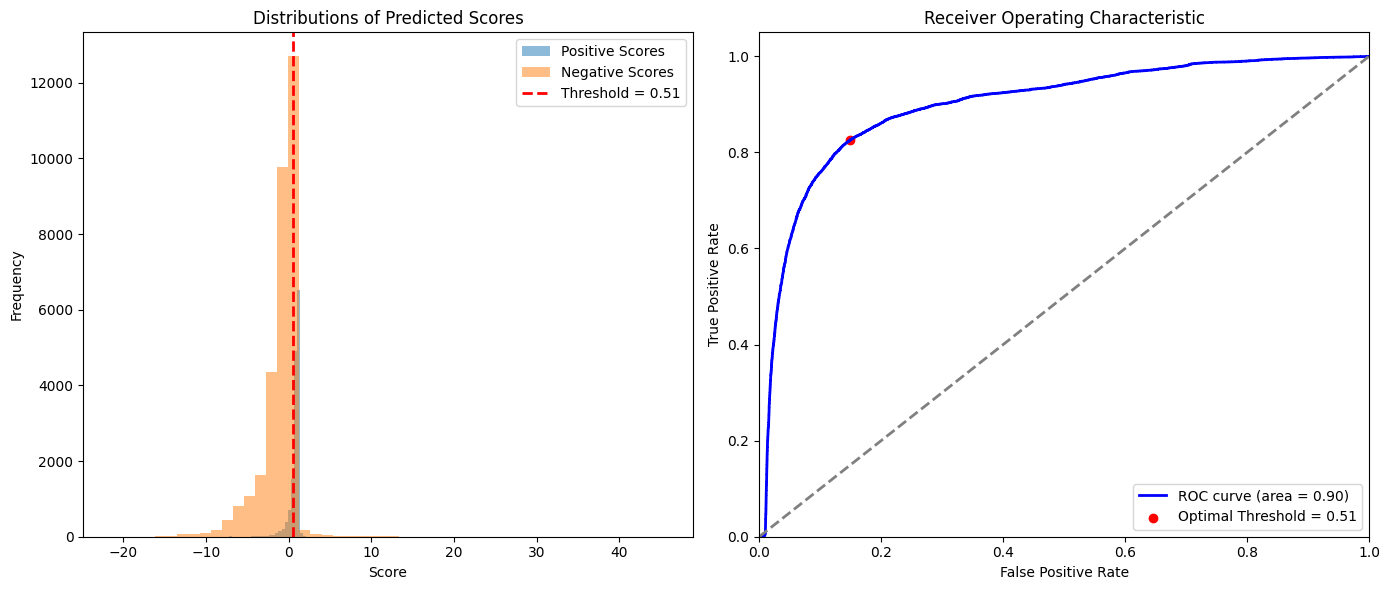

AUC: 0.8980577512188099


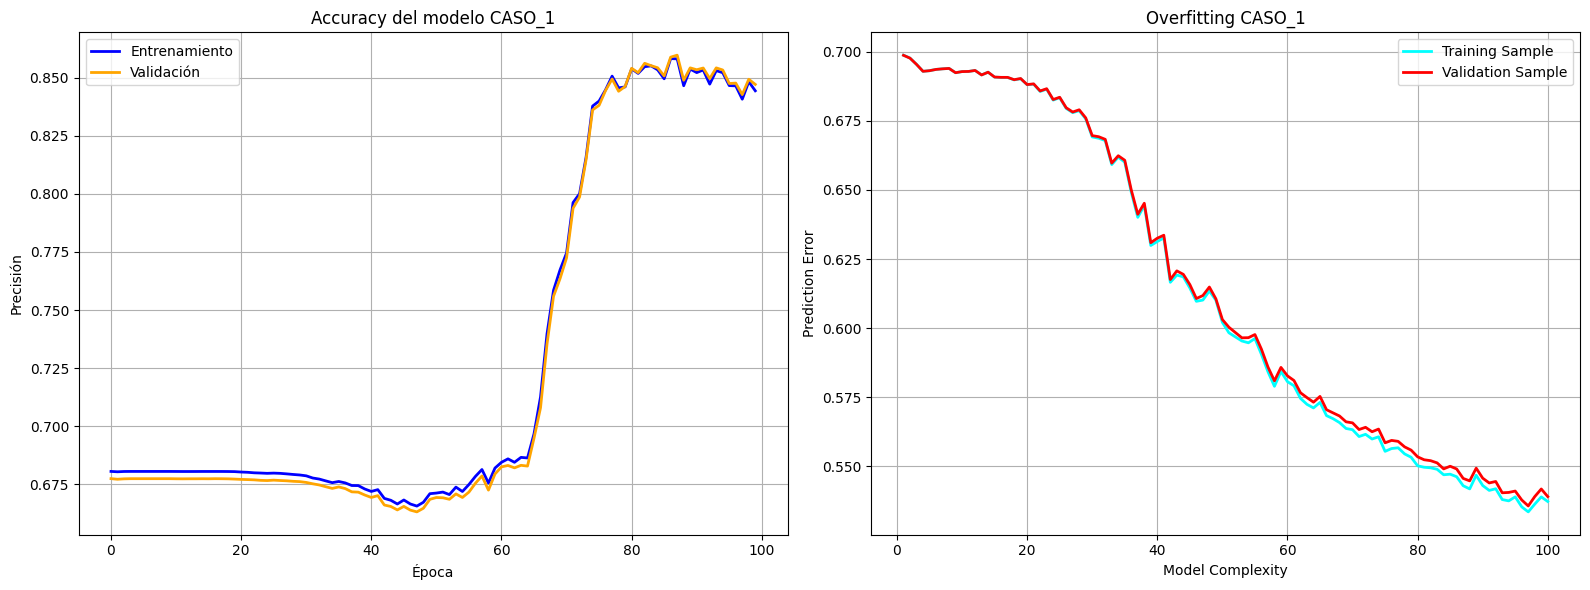

------------------------------------------------------
------------------------------------------------------
[CASO_2]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 369239
Validation edges: 46125
Test edges: 46525
MLP
In epoch 0, train loss: 0.7037891745567322, val loss: 0.7035382390022278
In epoch 20, train loss: 0.32531946897506714, val loss: 0.3227909207344055
In epoch 40, train loss: 0.26820507645606995, val loss: 0.26650023460388184
In epoch 60, train loss: 0.2393045425415039, val loss: 0.23696480691432953
In epoch 80, train loss: 0.220680832862854, val loss: 0.2179897129535675


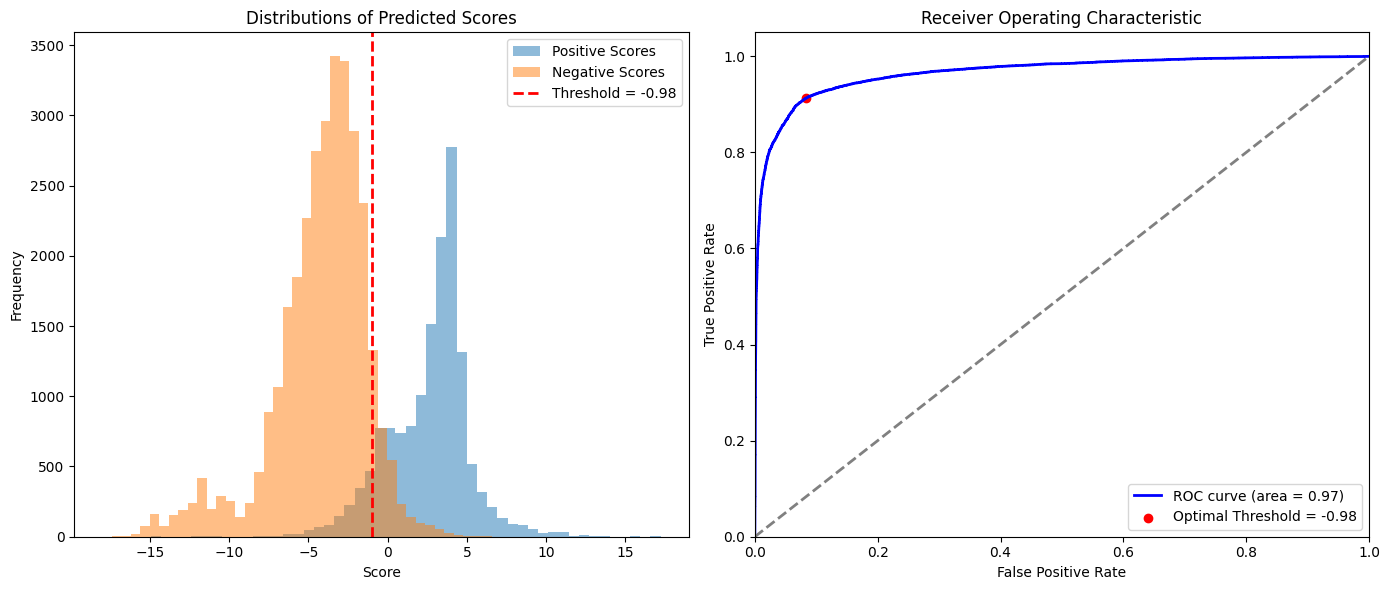

AUC: 0.9660902770199341


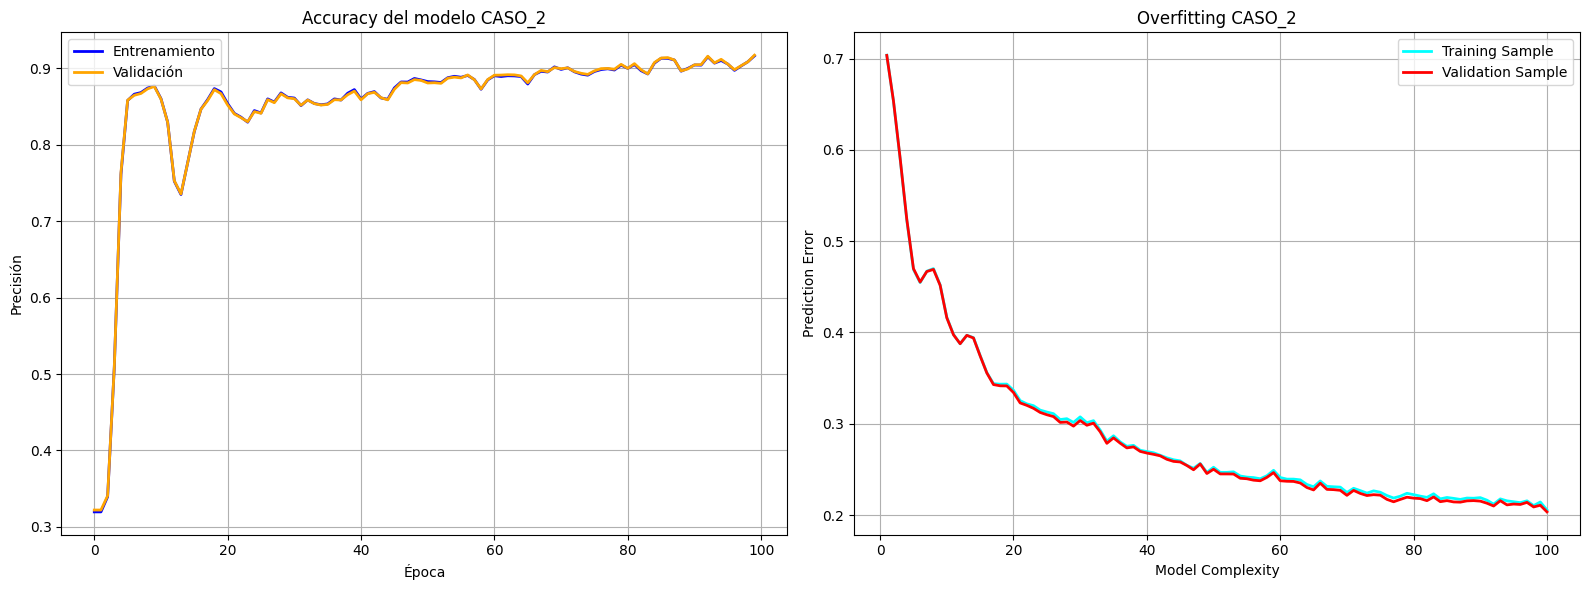

------------------------------------------------------
------------------------------------------------------
[CASO_3]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 369544
Validation edges: 46131
Test edges: 46214
DotPredictor
In epoch 0, train loss: 1.4817148447036743, val loss: 1.4780333042144775
In epoch 20, train loss: 0.6925327181816101, val loss: 0.6927962899208069
In epoch 40, train loss: 0.6483352780342102, val loss: 0.6484811902046204
In epoch 60, train loss: 0.6388964056968689, val loss: 0.6394630670547485
In epoch 80, train loss: 0.6070255041122437, val loss: 0.6108552813529968


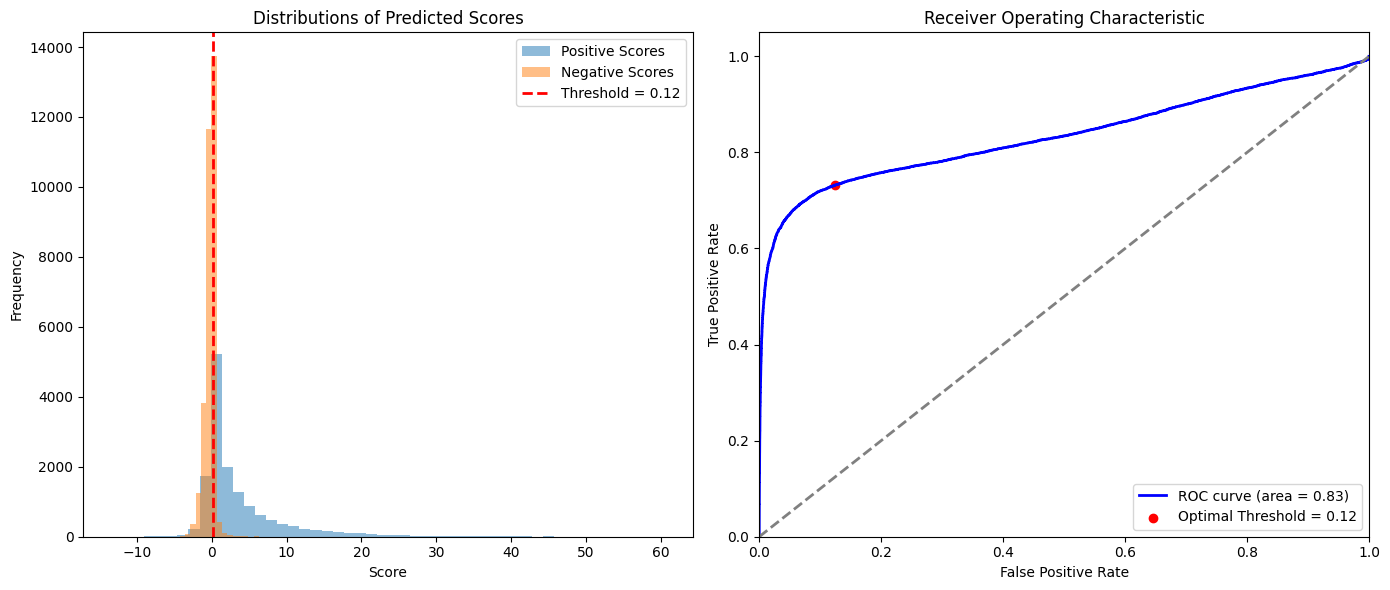

AUC: 0.8339563303907809


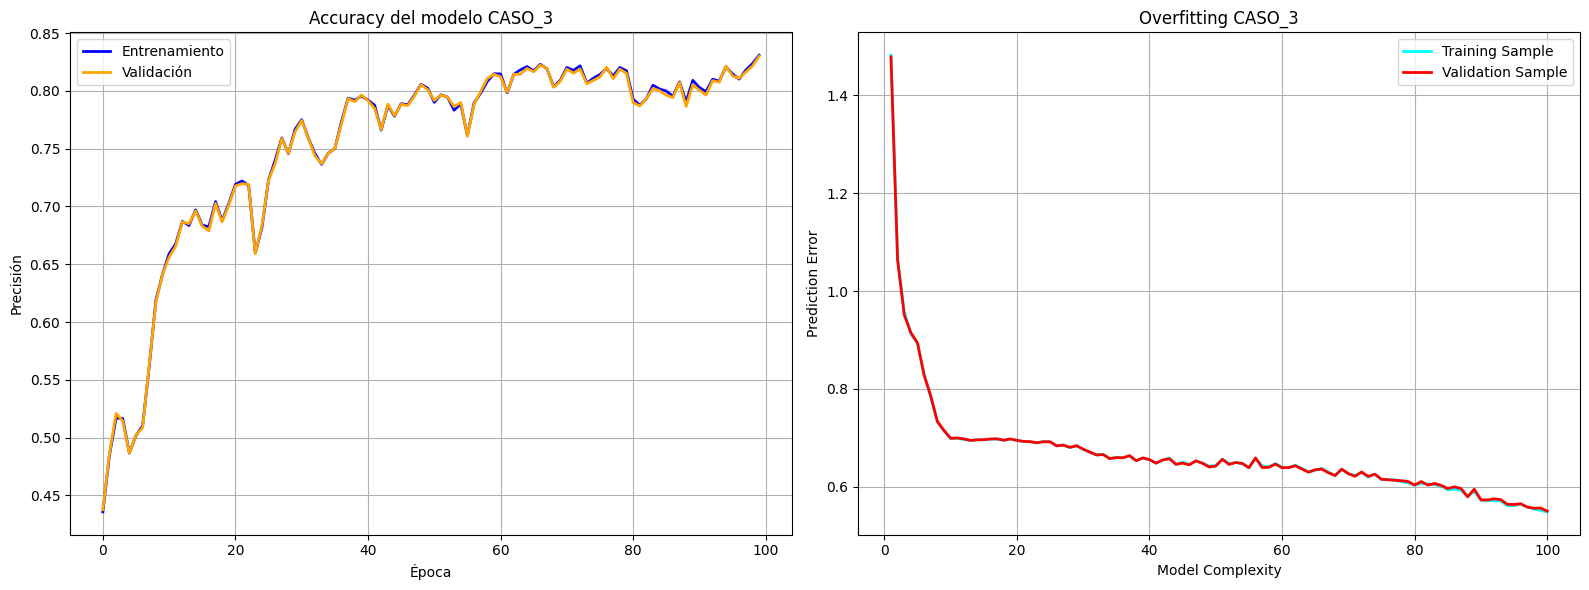

------------------------------------------------------
------------------------------------------------------
[CASO 4: GraphSAGE + MLPPredictor]


In [ ]:
for case_name, case in cases.items():
    print(f"[{case_name}]")

    data_path = case["data_path"]
    size_train = case["size_train"]

    # ----------- 1. Cargar grafo y preparar datos -------------- #
    gnn = load_and_prepare_data(data_path, size_train)
    

    # ----------- 2. Inicializa modelo -------------------------- #
    model = case["model"]
    predictor = case["predictor"]
    lr = 0.01
    if predictor == DotPredictor:
        print("DotPredictor")
        h_feats_model = 16
        out_feat_model = 2 # num clases
        model, pred, optimizer = initialize_model(gnn, model, predictor, lr, h_feats_model, out_feat_model)
    else:
        print("MLP")
        h_feats_model = 16
        out_feat_model = 32
        out_feat_predictor = 1 # num clases
        model, pred, optimizer = initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor)


    # ----------- 3. Entrenar modelo ----------------------------- #
    logits, train_error, val_error, acc_train, acc_val, model_complexity = train_model(case_name, gnn, model, pred, optimizer, epochs=100)

    # ----------- 4. Evaluar modelo ----------------------------- #
    optimal_threshold = evaluate_model(gnn, logits, gnn.test_mask)

    # ----------- 5. Plotear resultados ----------------------------- #
    plot_training(case_name,gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)

    print("------------------------------------------------------")
    print("------------------------------------------------------")